In [ ]:
import pandas as pd
from itertools import combinations, permutations
import networkx as gf
import scipy
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np


***Part I***

PCALG Implemention


In [ ]:
class myPC:
  def __init__(self,data,alpha):
        self.data = data
        self.alpha = alpha
        self.nodes = range(np.shape(self.data)[1])
        self.graph = gf.Graph()
  
  def fcGraph (self):
    self.graph = gf.Graph()
    self.graph.add_nodes_from(self.nodes)
    for (i, j) in combinations(self.nodes, 2):
          self.graph.add_edge(i, j)
          
  def __depenceTest__(self,x,y,set):
    X = self.data.iloc[:, x]
    Y = self.data.iloc[:, y]

    if (len(set) == 0):
        return myPC.__calculatePValue__(X,Y)
    else:
        index = 0
        Z = np.zeros([len(X), len(set)])
        for i in set:
            Z[:,index] = self.data.iloc[:, i]
            index += 1
        reg1 = LinearRegression().fit(Z,X)
        reg2 = LinearRegression().fit(Z,Y)
        return myPC.__calculatePValue__(reg1.predict(Z)-X,Y-reg2.predict(Z))
        
  def __calculatePValue__(x,y):
    r = np.corrcoef(x, y)[1,0]       
    z = 0.5*np.log((1+r)/(1-r))*np.sqrt(len(x)-3)
    pValue = scipy.stats.norm.sf(abs(z))*2
    return pValue

  def PCalgorithm (self):
    myPC.fcGraph(self)  
    level = -1
    while True:
        level +=1 
        for (i, j) in permutations(self.nodes, 2):
            adjacents = list(self.graph.neighbors(i))
            if j in adjacents: 
                adjacents.remove(j) 
                if len(adjacents)>=level:
                    for s in combinations(adjacents, level):
                        pValue = myPC.__depenceTest__(self,i, j, s)                    
                        if pValue > self.alpha:
                            self.graph.remove_edge(i, j)
                            break
        if(self.graph.number_of_nodes()<level):
            break
  def stablePCalgorithm (self):
    myPC.fcGraph(self)
    removed_edges = []
    level = 0
    while True:
        for (i, j) in permutations(self.nodes, 2):
            adjacents = list(self.graph.neighbors(i))
            if j in adjacents:
                adjacents.remove(j) 
                if len(adjacents)>=level: 
                    for s in combinations(adjacents,level):
                        pValue = myPC.__depenceTest__(self, i, j, s)                   
                        if pValue > self.alpha:
                            removed_edges.append((i, j))
                            break
        level += 1
        self.graph.remove_edges_from(removed_edges) 
        if (self.graph.number_of_nodes()<level):
            break

  def visualize(self):
    plt.figure()
    gf.draw_networkx(self.graph)
    plt.show()

کلاس پیاده سازی این الگوریتم به صورت زیر است که ابتدا یک گراف تمام متصل تشکیل می‌دهیم و سپس طبق الگوریتم و با استفاده از تست استقلال وجود یا عدم وجود یال ها را بررسی می‌کنیم.

***Part II***

finding causal skeleton on `pc-data.csv`

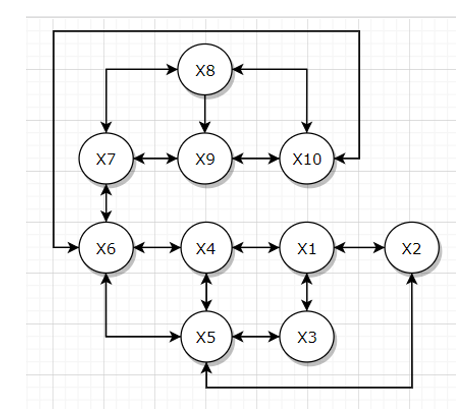

حال این الگوریتم را بر روی دیتای داده شده اجرا می‌کنیم که گراف علی را به شکل بالا به دست می آورد. 

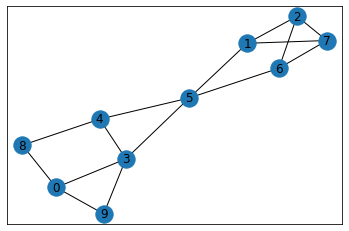

In [ ]:
data = pd.read_csv('data_PHW2.csv')
df = pd.DataFrame(data)
causal = myPC(data,0.02)
causal.PCalgorithm()
causal.visualize()

***Part III***

Implemention Stable PCALG and finding causal skeleton on `pc-data.csv`

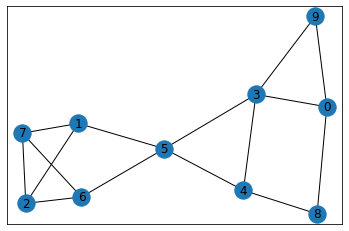

In [ ]:
causal.stablePCalgorithm()
causal.visualize()

با توجه به کوچک بودن دیتا، دو الگوریتم در جواب نهایی‌شون تفاوتی نداشتند.
هر چند که الگوریتم پایدار به دلیل دقت بیشتر در حذف یال بهتر عمل می‌کند.

***Part IV***

Missing and Recall rates using different alphas.
We implement two functions "rmvDag" and "randomDag"
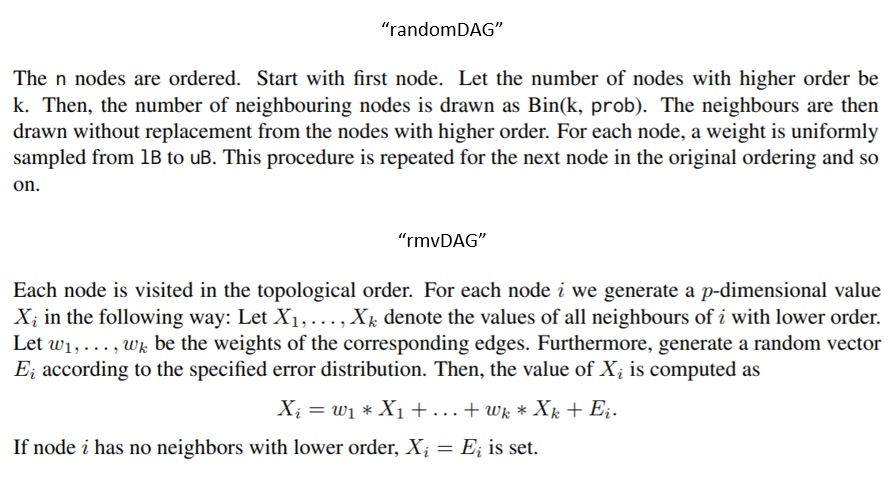



در این مرحله ابتدا باید یک گراف تصادفی با پارامترهای داده شده تولید کنیم و سپس با قرار دادن نویز گاوسی استاندارد برای هر تابع نویز، یک مجموعه داده تصادفی از این گراف تولید می‌کنیم که حال توسط الگوریتم جهت علی آن را به دست می آوریم و با یکدیگر مقایسه می‌کنیم.

In [ ]:
def compareGraph (realGraph,predictedGraph):
  nodes = range(20)
  totalEdge = realGraph.number_of_edges()
  recall = 0
  miss = 0
  realEdges = realGraph.edges
  predictedEdges = predictedGraph.edges

  for edge in combinations(nodes, 2):
      if (edge in realEdges and edge in predictedEdges):
        recall+=1
        pass
      if (edge in predictedEdges and edge not in realEdges):
        miss+=1
  return [recall/totalEdge,miss/totalEdge]
       
def myrandomDAG (nodeSize=20,p=0.2,lowerBound=0.1,upperBound=1):
  nodes = range(nodeSize)
  graph = gf.Graph()
  graph.add_nodes_from(nodes)
  for edge in combinations(nodes, 2):
      if (np.random.rand() < p):
        graph.add_edge(edge[0],edge[1],weight=np.random.uniform(lowerBound,upperBound))    
  return graph

def myrmvDAG (samples,graph):
  data = np.zeros((samples,graph.number_of_nodes()))
  for col in graph.nodes():
      data[:,col] = np.random.randn(samples)
      neighbors = graph.neighbors(col)
      for node in neighbors:
          if node < col:
              data[:,col] += graph.get_edge_data(node,col)['weight']*data[:,node]
  return data


alphas = [0.25/100,0.5/100,1/100,2/100]
experiments = 200
recall_simple = np.zeros((len(alphas),experiments))
missing_simple = np.zeros((len(alphas),experiments))
recall_stable = np.zeros((len(alphas),experiments))
missing_stable = np.zeros((len(alphas),experiments))

recall_sim = []
missing_sim = []
recall_sta = []
missing_sta = []

for i,alpha in enumerate(alphas):
  for index in range(experiments):
    graph = myrandomDAG()
    data = myrmvDAG(1000,graph)
    df = pd.DataFrame(data)
    causal = myPC(df,alpha)
    causal.PCalgorithm()
    simpleGraph = causal.graph
    [recall_simple[i,index],missing_simple[i,index]]=compareGraph(graph,simpleGraph)
    causal.stablePCalgorithm()
    stableGraph = causal.graph
    [recall_stable[i,index],missing_stable[i,index]]=compareGraph(graph,stableGraph)

  recall_sim.append(np.mean(recall_simple[i,:]))
  missing_sim.append(np.mean(missing_simple[i,:]))
  recall_sta.append(np.mean(recall_stable[i,:]))
  missing_sta.append(np.mean(missing_stable[i,:]))


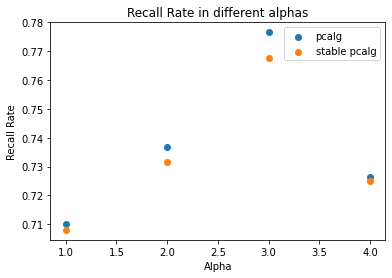

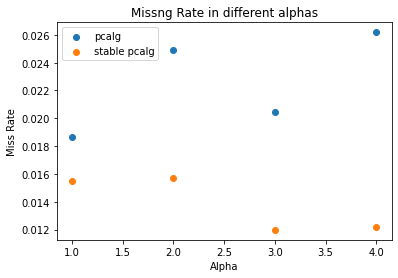

In [ ]:
plt.figure()
plt.scatter(range(1,5),recall_sim)
plt.scatter(range(1,5),recall_sta)
plt.title("Recall Rate in different alphas")
plt.legend(['pcalg','stable pcalg'])
plt.xlabel("Alpha")
plt.ylabel("Recall Rate")
plt.show()

plt.figure()
plt.scatter(range(1,5),missing_sim)
plt.scatter(range(1,5),missing_sta)
plt.title("Missng Rate in different alphas")
plt.legend(['pcalg','stable pcalg'])
plt.xlabel("Alpha")
plt.ylabel("Miss Rate")
plt.show()

در حالت کلی الگوریتم پایدار نسبت به نوع عادی آن باید بهتر جواب بدهد، چون الگوریتم ساده آن به نوعی متقارن نیست، یعنی اگر از نقاط مختلفی شروع به پیاده سازی الگوریتم کنیم، جواب متفاوت خواهد بود و هم چنین وقتی که در جا آن یال مشخص را جذف می‌کنیم، به نوعی اطلاعات از بین می‌رود و از پاسخ صحیح کمی دورتر می‌شویم. در نمودار میسینگ این پدیده دیده می‌شود که الگوریتم ساده خطای بیشتری نسبت به نوع پایدار آن دارد. هم چینن در نمودار ریکال تفاوت خاصی دیده نمی‌شود که این نشان می‌دهد الگوریتم هنوز خطای زیادی دارد.